In [1]:
!git clone https://github.com/HansBambel/multidim_conv.git

Cloning into 'multidim_conv'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 59 (delta 10), reused 12 (delta 3), pack-reused 34
Unpacking objects: 100% (59/59), 145.58 MiB | 13.83 MiB/s, done.


In [2]:
import pickle
import numpy as np
with open('./multidim_conv/data/Wind_data_NL/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('./multidim_conv/data/Wind_data_NL/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [3]:
train_data = data['train']
test_data = data['test']
train_data.shape

(70128, 7, 6)

In [4]:
scaler

{'Features': ['Wind speed in 0.1m/s',
  'Wind direction in degrees (360 North, 90 East, 0 No wind)',
  'Temperature in 0.1C',
  'Dew Point in 0.1C',
  'Air Pressure in 0.1hpa',
  'Rain amount in 0.1mm'],
 'feature_min_train': array([ 0.000e+00,  0.000e+00, -1.950e+02, -2.170e+02,  9.681e+03,
        -1.000e+00]),
 'feature_max_train': array([  240.,   360.,   376.,   230., 10462.,   481.])}

In [146]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def build_data(data, x_len, y_len, gap=1):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y


"""Build data and train test split"""
def make_ready_data(data, train=True, temp=False, gap=1):
    x_len = 10  # 10 historical time steps
    y_len = 1  # next step
    
    """we need the tempretaure in addition to the wind speed"""
    if temp:
        idx = 2
    else:
        idx = 0
        
    x, y = build_data(data[:, :, idx], x_len, y_len, gap) 
    x, y = x.reshape(x.shape[0], 10, 7), y.reshape(y.shape[0], 7)
    
    if train:
        xtrain = x[:60000]
        ytrain = y[:60000]
        xval = x[60000:]
        yval = y[60000:]
    
        return xtrain, xval, ytrain, yval
    else:
        return x, y

train_data = data['train']
test_data = data['test']

xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=1)

xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, temp=True, gap=1)

xtest, ytest = make_ready_data(test_data, train=False, gap=1)
xtest_temp, _ = make_ready_data(test_data, train=False, temp=True, gap=1)

xtrain.shape, xval.shape, ytrain.shape, yval.shape,xtest.shape, ytest.shape

((60000, 10, 7),
 (10116, 10, 7),
 (60000, 7),
 (10116, 7),
 (10860, 10, 7),
 (10860, 7))

In [147]:
import torch

def build_dl(xtrain, xval, xtest, xtrain_temp, xval_temp, xtest_temp, ytrain, yval, ytest):
    """convert arrays to tensors"""
    batch_size = 64
    xtrain = torch.Tensor(xtrain).to(device)
    ytrain = torch.Tensor(ytrain).to(device)
    xtrain_temp = torch.Tensor(xtrain_temp).to(device)
    xval = torch.Tensor(xval).to(device)
    yval = torch.Tensor(yval).to(device)
    xval_temp = torch.Tensor(xval_temp).to(device)
    xtest = torch.Tensor(xtest).to(device)
    ytest = torch.Tensor(ytest).to(device)
    xtest_temp = torch.Tensor(xtest_temp).to(device)
    train_data = torch.utils.data.TensorDataset(xtrain, xtrain_temp, ytrain)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    val_data = torch.utils.data.TensorDataset(xval, xval_temp, yval)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    test_data = torch.utils.data.TensorDataset(xtest, xtest_temp, ytest)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    
    return train_iter, val_iter, test_iter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, 
                                           xtrain_temp, xval_temp, 
                                           xtest_temp, ytrain, 
                                           yval, ytest)

In [150]:
from torch import nn
from torch.autograd import Variable
from collections import OrderedDict
    
class BiLinearPoolingLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(BiLinearPoolingLSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 10
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(((hidden_size*2)+1)**2, output_size)
        
        
    def forward(self, x1, x2):
        h1 = Variable(torch.zeros(self.num_layers*2, x1.size(0), self.hidden_size))
        c1 = Variable(torch.zeros(self.num_layers*2, x1.size(0), self.hidden_size))
        h2 = Variable(torch.zeros(self.num_layers*2, x2.size(0), self.hidden_size))
        c2 = Variable(torch.zeros(self.num_layers*2, x2.size(0), self.hidden_size))
        
        """Get the LSTM outputs, Hidden states (hn1, hn2) and 
        cell states(cn1, cn2) can be used also"""
        lstm_out1, (hn1, cn1) = self.lstm1(x1, (h1, c1))
        lstm_out2, (hn2, cn2) = self.lstm2(x2, (h2, c2))
        out1 = lstm_out1[:, -1, :]
        out2 = lstm_out2[:, -1, :]
        
        """add vectors of ones at the end of each matrix to account
        for each output alone before the cross multiplication, 
        This ideas is taken from paper: Multimodal Tensorfusion network"""
        out2_ones = out1_ones = torch.ones((out2.shape[0], 1))
        out2 = torch.cat((out2, out2_ones), 1)
        out1 = torch.cat((out1, out1_ones), 1)
        
        """We move the batch size to the last dimenstion to perform 
        matrix multiplications and add extra dimension...This is only a hack"""
        out1 = out1.view(out1.shape[-1], out1.shape[0])
        out2 = out2.view(out2.shape[-1], out2.shape[0])
        out2 = out2.unsqueeze(1)
        main_output = out1*out2
        
        
        """Now we reshape into batchsize vs 33*33 where each 32 is 
        the output of LSTM and 1 for the added ones vector"""
        main_output = torch.flatten(main_output)
        main_output = main_output.view(int(main_output.shape[0]/(33*33)), 33*33)
        out = self.linear(main_output)
    
        return out

In [151]:
"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x1, x2, y in val_iter:
            outputs = model(x1, x2)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss

"""Train loop"""
def run_train(model, num_epochs = 50):
    for epoch in range(num_epochs):
        losses = []
        #
        for x1, x2, y in train_iter:
            outputs = model(x1, x2)
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        train_loss = np.mean(losses)
        val_loss = validate(model) 
    
        if epoch % 2 == 0:
            print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)
                  
    return model


input_size = output_size = 7
hidden_size = 16
num_layers = 1
lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model, num_epochs=10)

Epoch:  1 , Train Loss:  0.0031480898008074193 , Val Loss:  0.001975232
Epoch:  3 , Train Loss:  0.0017283547090427048 , Val Loss:  0.0018490163
Epoch:  5 , Train Loss:  0.0014841176370202975 , Val Loss:  0.0019153691
Epoch:  7 , Train Loss:  0.001403662191926321 , Val Loss:  0.0019461835
Epoch:  9 , Train Loss:  0.0013827133413924495 , Val Loss:  0.0019097587


In [152]:
"""Test data predictions"""
def run_test(model):
    model.eval()
    y_preds = list()
    y_true = list()

    max_wind = scaler['feature_max_train'][0]
    min_wind = scaler['feature_min_train'][0]

    with torch.no_grad():
        for x1, x2, y in test_iter:
            y = y.cpu().numpy().reshape(-1)
            y_pred = model(x1, x2).view(len(y), -1).cpu().numpy().reshape(-1)
            y = y * max_wind + min_wind
            y_pred = y_pred * max_wind + min_wind
            y_preds.extend(list(y_pred))
            y_true.extend(list(y))
        
    y_preds = np.array(y_preds)
    y_true = np.array(y_true)
    y_true = y_true.reshape(int(y_true.shape[0]/7), 7)
    y_preds = y_preds.reshape(int(y_preds.shape[0]/7), 7)
    
    return y_true, y_preds

y_true, y_preds = run_test(lstm_model)

RMSE:  11.49185
MAE:  7.4958935


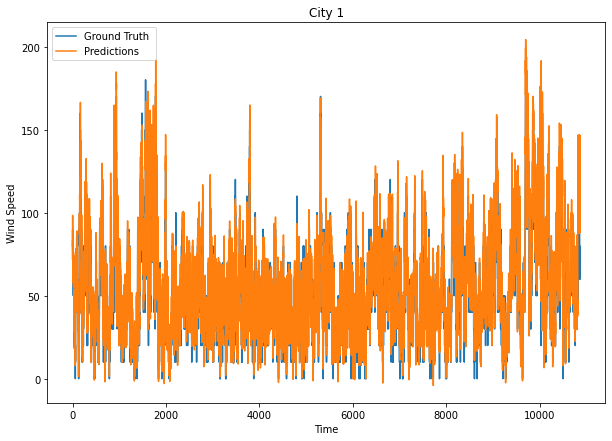

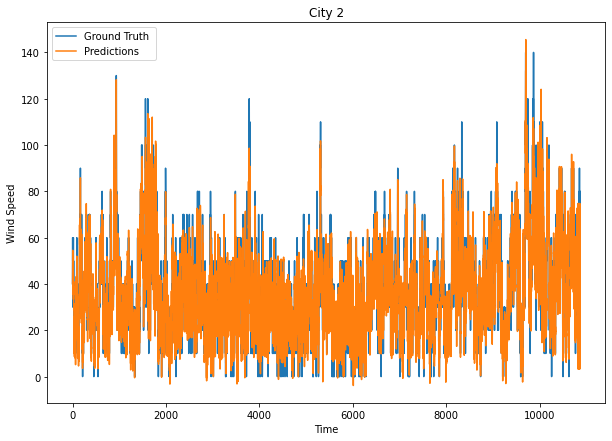

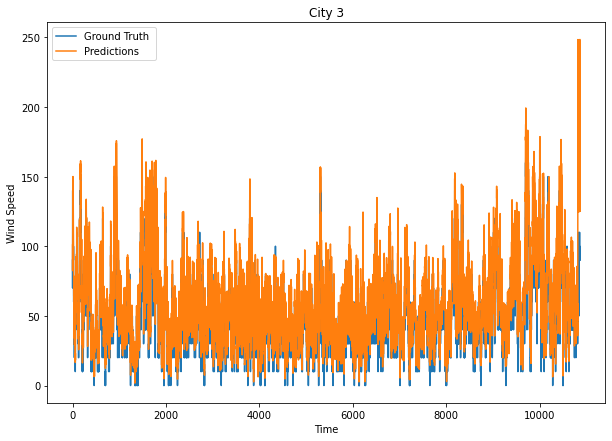

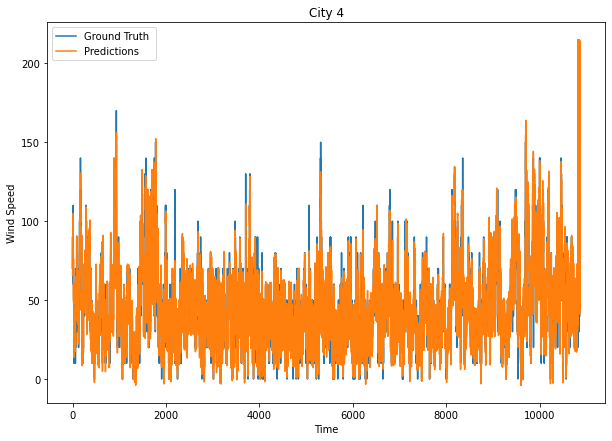

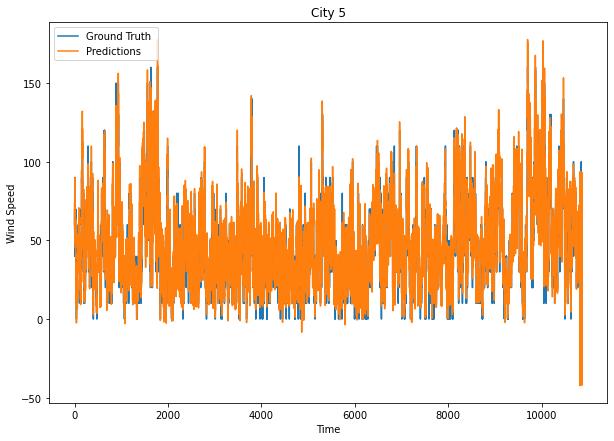

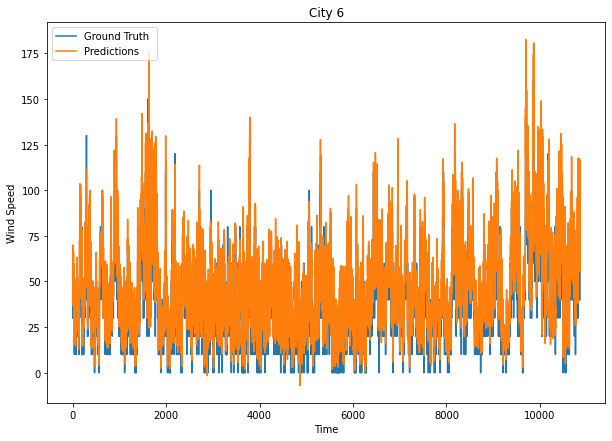

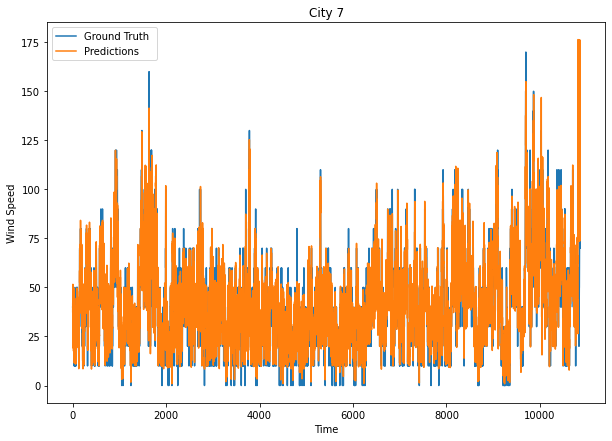

In [153]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def results(y_true, y_preds, plots=True):
    """Visualization of windspeed predictions vs ground truth and
    Overall evaluation the predictions of the test data"""
    
    print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
    print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

    if plots:
        for i in range(7):
            plt.figure(figsize=(10,7))
            plt.plot(range(len(y_true[:, i])), y_true[:, i], label='Ground Truth ')
            plt.plot(range(len(y_preds[:, i])), y_preds[:, i], label='Predictions')
            plt.title('City '+str(i+1))
            plt.xlabel('Time')
            plt.ylabel('Wind Speed')
            plt.legend(loc="upper left")
            plt.show()
        
results(y_true, y_preds, plots=True)

## 5 Hours ahead

In [156]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=5)
xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, temp=True, gap=5)
xtest, ytest = make_ready_data(test_data, train=False, gap=5)
xtest_temp, _ = make_ready_data(test_data, train=False, temp=True, gap=5)

train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, 
                                           xtrain_temp, xval_temp, 
                                           xtest_temp, ytrain, 
                                           yval, ytest)

lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model, num_epochs=10)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.004647837617798948 , Val Loss:  0.003761278
Epoch:  3 , Train Loss:  0.0034306661492940396 , Val Loss:  0.0032406254
Epoch:  5 , Train Loss:  0.0031695497514027705 , Val Loss:  0.0030315476
Epoch:  7 , Train Loss:  0.0030565283562578975 , Val Loss:  0.0029440876
Epoch:  9 , Train Loss:  0.0029424695371424777 , Val Loss:  0.0028793933
Test Data:
RMSE:  13.562074
MAE:  9.372997


## 10 Hours ahead

In [157]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=10)
xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, temp=True, gap=10)
xtest, ytest = make_ready_data(test_data, train=False, gap=10)
xtest_temp, _ = make_ready_data(test_data, train=False, temp=True, gap=10)

train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, 
                                           xtrain_temp, xval_temp, 
                                           xtest_temp, ytrain, 
                                           yval, ytest)

lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model, num_epochs=10)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.006087865517003093 , Val Loss:  0.004812615
Epoch:  3 , Train Loss:  0.004749287180711767 , Val Loss:  0.0044372045
Epoch:  5 , Train Loss:  0.0045647625749342955 , Val Loss:  0.00440992
Epoch:  7 , Train Loss:  0.004464780965791161 , Val Loss:  0.004417982
Epoch:  9 , Train Loss:  0.004369757309464662 , Val Loss:  0.0044118045
Test Data:
RMSE:  16.329933
MAE:  11.654685


In [158]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=50)
xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, temp=True, gap=50)
xtest, ytest = make_ready_data(test_data, train=False, gap=50)
xtest_temp, _ = make_ready_data(test_data, train=False, temp=True, gap=50)

train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, 
                                           xtrain_temp, xval_temp, 
                                           xtest_temp, ytrain, 
                                           yval, ytest)

lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model, num_epochs=10)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.009234530256384972 , Val Loss:  0.007963298
Epoch:  3 , Train Loss:  0.008419026592885381 , Val Loss:  0.008002017
Epoch:  5 , Train Loss:  0.008295144163829678 , Val Loss:  0.008066227
Epoch:  7 , Train Loss:  0.008220253523681432 , Val Loss:  0.008145764
Epoch:  9 , Train Loss:  0.008167177131439227 , Val Loss:  0.008234359
Test Data:
RMSE:  22.891207
MAE:  17.447762


## References:

- Dataset from "Trebing, Kevin and Mehrkanoon, Siamak, 2020, Wind speed prediction using multidimensional convolutional neural networks"